In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import scipy.stats as stats
import ast
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score , confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

C:\Users\afspf\anaconda3\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [1473]:
data = pd.read_csv("train.csv")

In [1474]:
data.drop(columns = ["country", "weight", "encounter_id", "patient_id", 'readmitted_multiclass'], inplace = True)

In [1475]:
data = data[~(data["gender"] == "Unknown/Invalid")]

In [1476]:
data["race"] = data["race"].replace({"?": np.nan})
data["payer_code"].replace({"?":np.nan}, inplace = True)
data["admission_type"].replace({"?":np.nan, "Not Mapped":np.nan, "Not Available": np.nan}, inplace = True)
data["medical_specialty"].replace({"?":np.nan}, inplace = True)
data["discharge_disposition"] = data["discharge_disposition"].replace({"?": np.nan, "Not Mapped":np.nan})
data["admission_source"] = data["admission_source"].replace({ "?":np.nan, " Not Mapped":np.nan, " Not Available":np.nan})
data["primary_diagnosis"].replace({"?": np.nan}, inplace = True)
data["secondary_diagnosis"].replace({"?":np.nan}, inplace = True)
data["additional_diagnosis"].replace({"?":np.nan}, inplace = True)
data["glucose_test_result"].replace({"?": np.nan}, inplace = True)

In [1477]:
ten_spec = ["Missing", "InternalMedicine", "Emergency/Trauma", "Family/GeneralPractice", "Cardiology", "Surgery-General", "Nephrology", "Orthopedics", "Orthopedics-Reconstructive", "Radiologist"]
data["med_spe"] = data["medical_specialty"].copy()
data.loc[~data.med_spe.isin(ten_spec), "med_spe"] = "Other"
data.drop(columns = "medical_specialty", inplace = True)

In [1478]:
# they dead lol
data["discharge_disposition"].value_counts()
death = ["Expired", "Hospice / medical facility", "Hospice / home", "Expired at home. Medicaid only, hospice.", "Expired in a medical facility. Medicaid only, hospice."]
data = data[~data["discharge_disposition"].isin(death)]

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9961750/

In [1479]:
data["presence_MD"] = (data["payer_code"] == "MD").astype("int")

In [1480]:
data["presence_MC"] = (data["payer_code"] == "MC").astype("int")

In [1481]:
data["no_insurande"] = (pd.isna(data["payer_code"])).astype("int")

In [1482]:
data["is_black"] = (data["race"] == "AfricanAmerican").astype("int")

_________

In [1483]:
data_enc = data.copy()

In [1484]:
def encode(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    return df

In [1488]:
import re

def extract_medications(row):
    medications_str = row['medication']
    if medications_str and medications_str != '[]':
        return re.findall(r"'([^']*)'", medications_str)
    else:
        return []

In [1486]:
def medication_encoder(df):
    mlb = MultiLabelBinarizer(sparse_output=False)
    mlb_result = mlb.fit_transform(df.pop('medication'))
    mlb_df = pd.DataFrame(mlb_result, index=df.index, columns=mlb.classes_).astype(int)
    df = df.join(mlb_df)
    return df

In [1489]:
data_enc["medication"] = data_enc.apply(extract_medications, axis = 1)

In [1490]:
data_enc["num_medication"] = data_enc["medication"].apply(lambda x: len(x))

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9961750/

In [1492]:
data_enc['insulin_intake'] = (data_enc['medication'].apply(lambda meds: 'insulin' in meds)).astype("int")

In [1493]:
data_enc['metmorfin_intake'] = (data_enc['medication'].apply(lambda meds: 'metformin' in meds)).astype("int")

In [1494]:
data_enc.drop(columns = "medication", inplace = True)

https://www.mdpi.com/2077-0383/12/4/1274

https://www.aapc.com/codes/icd9-codes-range/33/

http://mchp-appserv.cpe.umanitoba.ca/reference/Candata_web_final.pdf#page=92

In [1412]:
comorbidity_weights = {
    '410': 1, '412': 1,  # Myocardial Infarction
    '398.91': 1, '402.01': 1, '402.11': 1, '402.91': 1, '404.01': 1, 
    '404.03': 1, '404.11': 1, '404.13': 1, '404.91': 1, '404.93': 1, 
    '425.4': 1, '425.5': 1, '425.6': 1, '425.7': 1, '425.8': 1, '425.9': 1, 
    '428': 1,  # Congestive Heart Failure
    '093.0': 1, '437.3': 1, '440': 1, '441': 1, '443.1': 1, '443.9': 1, 
    '447.1': 1, '557.1': 1, '557.9': 1, 'V43.3': 1,  # Peripheral Vascular Disease
    '362.34': 1, '430': 1, '431': 1, '432': 1, '433': 1, '434': 1, '435': 1, 
    '436': 1, '437': 1, '438': 1,  # Cerebrovascular Disease
    '290': 1, '294.1': 1, '331.2': 1,  # Dementia
    '416.8': 1, '416.9': 1, '490': 1, '491': 1, '492': 1, '493': 1, '494': 1, 
    '495': 1, '496': 1, '506.4': 1, '508.1': 1, '508.8': 1,  # Chronic Pulmonary Disease
    '446.5': 1, '710.0': 1, '710.1': 1, '710.2': 1, '710.3': 1, '710.4': 1, 
    '714.0': 1, '714.1': 1, '714.2': 1, '714.8': 1, '725': 1,  # Connective Tissue Disease-Rheumatic Disease
    '531': 1, '532': 1, '533': 1, '534': 1,  # Peptic Ulcer Disease
    '070.22': 1, '070.23': 1, '070.32': 1, '070.33': 1, '070.44': 1, 
    '070.54': 1, '070.6': 1, '070.9': 1, '570': 1, '571': 1, '573.3': 1, 
    '573.04': 1, '573.08': 1, '573.09': 1, 'V42.07': 1,  # Mild Liver Disease
    '250.0': 1, '250.01': 1, '250.02': 1, '250.03': 1, '250.08': 1, '250.09': 1,  # Diabetes without Chronic Complications
    '250.4': 2, '250.5': 2, '250.6': 2, '250.7': 2,  # Diabetes with Chronic Complications
    '334.1': 2, '342': 2, '343': 2, '344.0': 2, '344.1': 2, '344.2': 2, 
    '344.3': 2, '344.4': 2, '344.5': 2, '344.6': 2,     '344.9': 2,  # Paraplegia and Hemiplegia
    '403.01': 2, '403.11': 2, '403.91': 2, '404.02': 2, '404.03': 2, 
    '404.12': 2, '404.13': 2, '404.92': 2, '404.93': 2, '582': 2, 
    '583.0': 2, '583.1': 2, '583.2': 2, '583.3': 2, '583.4': 2, '583.5': 2, 
    '583.6': 2, '583.7': 2, '585': 2, '586': 2, '588.0': 2, 'V42.0': 2, 
    'V45.1': 2, 'V56': 2,  # Renal Disease
    '140': 2, '141': 2, '142': 2, '143': 2, '144': 2, '145': 2, '146': 2, 
    '147': 2, '148': 2, '149': 2, '150': 2, '151': 2, '152': 2, '153': 2, 
    '154': 2, '155': 2, '156': 2, '157': 2, '158': 2, '159': 2, '160': 2, 
    '161': 2, '162': 2, '163': 2, '164': 2, '165': 2, '166': 2, '167': 2, 
    '168': 2, '169': 2, '170': 2, '171': 2, '172': 2, '174': 2, '175': 2, 
    '176': 2, '177': 2, '178': 2, '179': 2, '180': 2, '181': 2, '182': 2, 
    '183': 2, '184': 2, '185': 2, '186': 2, '187': 2, '188': 2, '189': 2, 
    '190': 2, '191': 2, '192': 2, '193': 2, '194': 2, '195': 2, '196': 2, 
    '197': 2, '198': 2, '199': 2, '200': 2, '201': 2, '202': 2, '203': 2, 
    '204': 2, '205': 2, '206': 2, '207': 2, '208': 2, '238.06': 2,  # Cancer
    '456.0': 3, '456.01': 3, '456.2': 3, '572.2': 3, '572.3': 3, '572.4': 3, 
    '572.8': 3,  # Moderate or Severe Liver Disease
    '196': 6, '197': 6, '198': 6, '199': 6,  # Metastatic Carcinoma
    '042': 6, '043': 6, '044': 6,  # HIV/AIDS
}

In [1413]:
def calculate_comorbidity_score(row):
    score = 0
    for diagnosis in [row['primary_diagnosis'], row['secondary_diagnosis']]:
        for code in str(diagnosis).split(','):
            if code.strip() in comorbidity_weights:
                score += comorbidity_weights[code.strip()]
    return score

In [1414]:
data_enc['comorbidity_score'] = data_enc.apply(calculate_comorbidity_score, axis=1)

In [1416]:
chronic_compli_diabetes = ['250.04', '250.05', '250.06', '250.07' ]  # Diabetes with Chronic Complications
    
cancer = ["140", "141", "142", "143", "144", "145", "146", "147", "148", "149", 
"150", "151", "152", "153", "154", "155", "156", "157", "158", "159", 
"160", "161", "162", "163", "164", "165", "166", "167", "168", "169", 
"170", "171", "172", "174", "175", "176", "177", "178", "179", "180", 
"181", "182", "183", "184", "185", "186", "187", "188", "189", "190", 
"191", "192", "193", "194", "195", "196", "197", "198", "199", "200", 
"201", "202", "203", "204", "205", "206", "207", "208", "238.06"
]

def has_chronic_diabetes(row):
    for diagnosis in [row['primary_diagnosis'], row['secondary_diagnosis']]:
        if pd.notna(diagnosis) and (str(diagnosis) in (chronic_compli_diabetes)):
            return 1
    return 0
def chronic(row):
    for diagnosis in [row['primary_diagnosis'], row['secondary_diagnosis']]:
        if pd.notna(diagnosis) and (str(diagnosis) in (cancer)):
            return 1
    return 0
def dka(row):
    for diagnosis in [row['primary_diagnosis'], row['secondary_diagnosis'], row['additional_diagnosis']]:
        if pd.notna(diagnosis) and (str(diagnosis) == '250.1' or str(diagnosis) == '240.1'):
            return 1
    return 0
def anemia(row):
    for diagnosis in [row['primary_diagnosis'], row['secondary_diagnosis'], row['additional_diagnosis']]:
        if pd.notna(diagnosis) and (str(diagnosis) == '280'):
            return 1
    return 0

In [1417]:
data_enc["diabeted_dka"] = data_enc.apply(dka, axis = 1)
data_enc["anemia"] = data_enc.apply(anemia, axis = 1)
data_enc["chronic_diabetes"] = data_enc.apply(has_chronic_diabetes, axis = 1)
data_enc["cancer"] = data_enc.apply(chronic, axis = 1)

In [1418]:
def diabetes_mellitus(row):
    for diagnosis in [row['primary_diagnosis']]:
        if pd.notna(diagnosis) and (str(diagnosis).startswith('250') or str(diagnosis) == '250'):
            return 1
    return 0
def diabetes_mellitus_2(row):
    for diagnosis in [row['secondary_diagnosis']]:
        if pd.notna(diagnosis) and (str(diagnosis).startswith('250') or str(diagnosis) == '250'):
            return 1
    return 0

In [1419]:
data_enc['diabetes_mellitus_primary'] = data_enc.apply(diabetes_mellitus, axis=1)
data_enc['diabetes_mellitus_secondary'] = data_enc.apply(diabetes_mellitus_2, axis=1)

In [1420]:

def has_type_i_diabetes(row):
    for diagnosis in [row['primary_diagnosis'], row['secondary_diagnosis']]:
        if pd.notna(diagnosis) and (str(diagnosis).startswith('250') or str(diagnosis) == '250'):
            return 1
    return 0

def has_type_ii_diabetes(row):
    for diagnosis in [row['primary_diagnosis'], row['secondary_diagnosis']]:
        if pd.notna(diagnosis) and (str(diagnosis).startswith('249') or str(diagnosis) == '249'):
            return 1
    return 0


In [1421]:
data_enc['has_type_i_diabetes'] = data_enc.apply(has_type_i_diabetes, axis=1)
data_enc['has_type_ii_diabetes'] = data_enc.apply(has_type_ii_diabetes, axis=1)

In [1422]:
def map_diag_codes(df, column):
    def map_code(code):
            if pd.isna(code):
                return 0
            if code[0] in ('V', 'E'):
                return {'V': 18, 'E': 19}[code[0]]
            if code.startswith("250."):
                return 20
            if code.startswith("140."):
                return 21
            code = float(code)
            code_ranges = [(1, 140, 1), (140, 240, 2), (240, 280, 3), (280, 290, 4), 
                           (290, 320, 5), (320, 390, 6), (390, 460, 7), (460, 520, 8), 
                           (520, 580, 9), (580, 630, 10), (630, 680, 11), (680, 710, 12), 
                           (710, 740, 13), (740, 760, 14), (760, 780, 15), (780, 800, 16), 
                           (800, 1000, 17)]

            for start, end, val in code_ranges:
                if start <= code < end:
                    return val
            return 0

    df[column] = df[column].apply(map_code)
    return df

In [1423]:
age_mapping = {
    '[0-10)': 0,
    '[10-20)': 0,
    '[20-30)': 0,
    '[30-40)': 1,
    '[40-50)': 2,
    '[50-60)': 3,
    '[60-70)': 4,
    '[70-80)': 5,
    '[80-90)': 6,
    '[90-100)': 7,
    np.nan:8,
}

In [1424]:
glucose_mapping = {
    np.nan: 0,
    '>300': 1,
    'Norm': 0,
    '>200': 1,
}

In [1425]:
ac1_mapping = {
    np.nan: 0,
    '>8': 1,
    'Norm': 0,
    '>7': 1,
}

In [1426]:
gender_mapping = {
    'Female': 0,
    'Male': 1,
}

In [1427]:
change_meds_mapping = {
    'No': 0,
    'Ch': 1,
}

In [1428]:
pdiabetes_meds_mapping = {
    'No': 0,
    'Yes': 1,
}

In [1429]:
data_enc['glucose_test_result'] = (data_enc['glucose_test_result'].map(glucose_mapping)).astype("int")

In [1430]:
data_enc['age'] = (data_enc['age'].map(age_mapping)).astype("int")

In [1431]:
data_enc['a1c_test_result'] = (data_enc['a1c_test_result'].map(ac1_mapping)).astype("int")

In [1432]:
data_enc['gender'] =( data_enc['gender'].map(gender_mapping)).astype("int")

In [1433]:
data_enc['change_in_meds_during_hospitalization'] = (data_enc['change_in_meds_during_hospitalization'].map(change_meds_mapping)).astype("int")

In [1434]:
data_enc['prescribed_diabetes_meds'] = (data_enc['prescribed_diabetes_meds'].map(pdiabetes_meds_mapping)).astype("int")

In [1435]:
data_enc = encode(data_enc, 'race')
data_enc = encode(data_enc, 'payer_code')
data_enc = encode(data_enc, 'med_spe')
data_enc = encode(data_enc, 'discharge_disposition')
data_enc = encode(data_enc, 'admission_source')
data_enc = encode(data_enc, 'admission_type')

In [1436]:
data_enc = map_diag_codes(data_enc, "primary_diagnosis")
data_enc = map_diag_codes(data_enc, "secondary_diagnosis")
data_enc = map_diag_codes(data_enc, "additional_diagnosis")

In [1437]:
bins = [-np.inf, 0, 2, 4, np.inf]
labels = ['0', '1-2', '3-4', '5+']
data_enc['inpatient_visits_bins'] = pd.cut(data_enc['inpatient_visits_in_previous_year'], bins=bins, labels=labels)
data_enc = encode(data_enc, "inpatient_visits_bins")
data_enc['inpatient_visits_x_medications'] = data_enc['inpatient_visits_in_previous_year'] * data_enc['number_of_medications']

___________________

In [1380]:
labelencoder = LabelEncoder()
y_binary = labelencoder.fit_transform(data_enc['readmitted_binary'])
data_enc.drop(columns = "readmitted_binary", inplace = True)

In [1381]:
numerical_features = ["outpatient_visits_in_previous_year", "emergency_visits_in_previous_year", "inpatient_visits_in_previous_year", "length_of_stay_in_hospital", "number_lab_tests", "non_lab_procedures", "number_of_medications", "number_diagnoses", "num_medication", "average_pulse_bpm"]
cat_features = [col for col in data_enc.columns if col not in numerical_features]

In [1382]:
def cor_heatmap(cor):
    plt.figure(figsize=(9,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

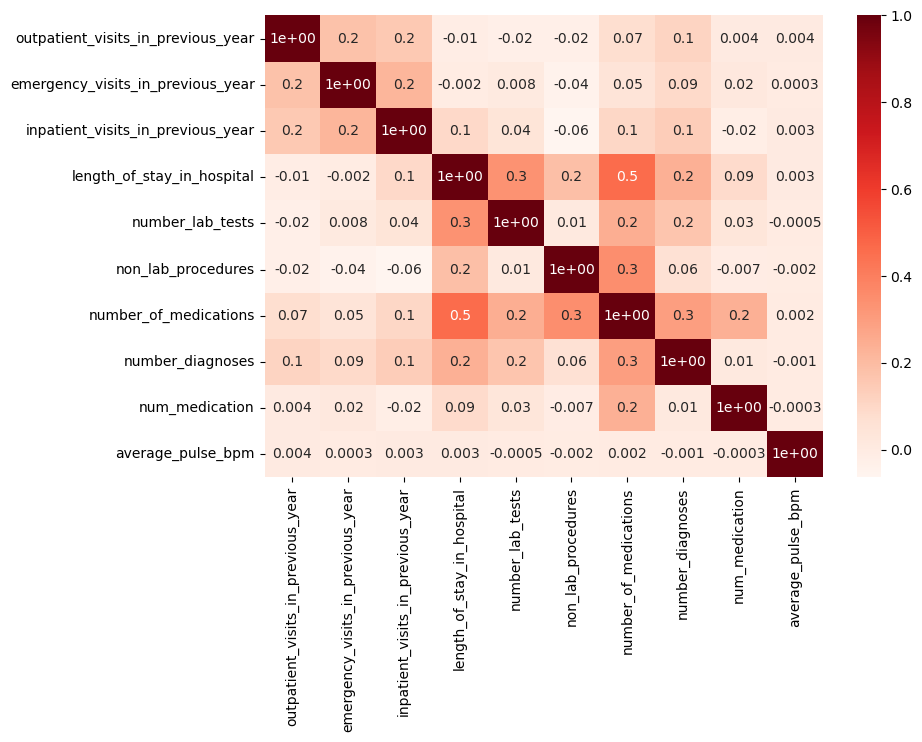

In [1045]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(data_enc[numerical_features])
num_scaled =  pd.DataFrame(num_scaled, columns = data_enc[numerical_features].columns).set_index( data_enc[numerical_features].index)
cor_spearman = num_scaled.corr(method ='spearman')
cor_heatmap(cor_spearman)

In [1097]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import pandas as pd
X = data_enc.copy()
y = y_binary
train_f1_scores = []
num_models = 6
f1_scores = []
conf_matrices = []
n_splits = 4
best_f1_score = -1
best_model = None
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in cv.split(X, y_binary):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]
    class_one = X_train[y_train == 1]
    class_zero = X_train[y_train == 0]
    subsets = np.array_split(class_zero.sample(frac=1, random_state=42), num_models)
    
    models = []
    for sub in subsets:
        X_sub = pd.concat([class_one, sub])
        y_sub = np.concatenate([np.ones(len(class_one)), np.zeros(len(sub))])
        model = HistGradientBoostingClassifier()
        model.fit(X_sub, y_sub)
        models.append(model)
    
    train_ensemble_p = np.mean(np.array([m.predict_proba(X_train)[:, 1] for m in models]), axis=0)
    train_ensemble_p = np.round(train_ensemble_p).astype(int)
    
    train_fold_f1 = f1_score(y_train, train_ensemble_p)
    train_f1_scores.append(train_fold_f1)

    all_p = np.array([m.predict_proba(X_test)[:, 1] for m in models])
    ensemble_p = np.mean(all_p, axis=0)
    ensemble_p = np.round(ensemble_p).astype(int)
    fold_f1 = f1_score(y_test, ensemble_p)
    f1_scores.append(fold_f1)

    fold_conf_matrix = confusion_matrix(y_test, ensemble_p)
    conf_matrices.append(fold_conf_matrix)


    fold_f1 = f1_score(y_test, ensemble_p)


    if fold_f1 > best_f1_score:
        best_f1_score = fold_f1
        best_model = models
        
average_f1 = np.mean(f1_scores)
print("Avg F1 Score:", average_f1)
total_conf_matrix = np.sum(conf_matrices, axis=0)
print("Total Confusion Matrix:\n", total_conf_matrix)
total_train_f1_scores = np.mean(train_f1_scores)
print("Train F1 Score:", total_train_f1_scores)

Avg F1 Score: 0.28663552239829415
Total Confusion Matrix:
 [[48702 12947]
 [ 4431  3492]]
Train F1 Score: 0.3439858201494649


In [657]:
from sklearn.tree import export_graphviz

def plot_tree(model):
    dot_data = export_graphviz(model,
                               feature_names=X_train.columns,
                               filled=True)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"20,20"')
    return graphviz.Source(pydot_graph.to_string())

In [1327]:
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size = 0.2, random_state = 15)
dt_mae = DecisionTreeRegressor(criterion="absolute_error", max_depth=5)
dt_mae.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5)

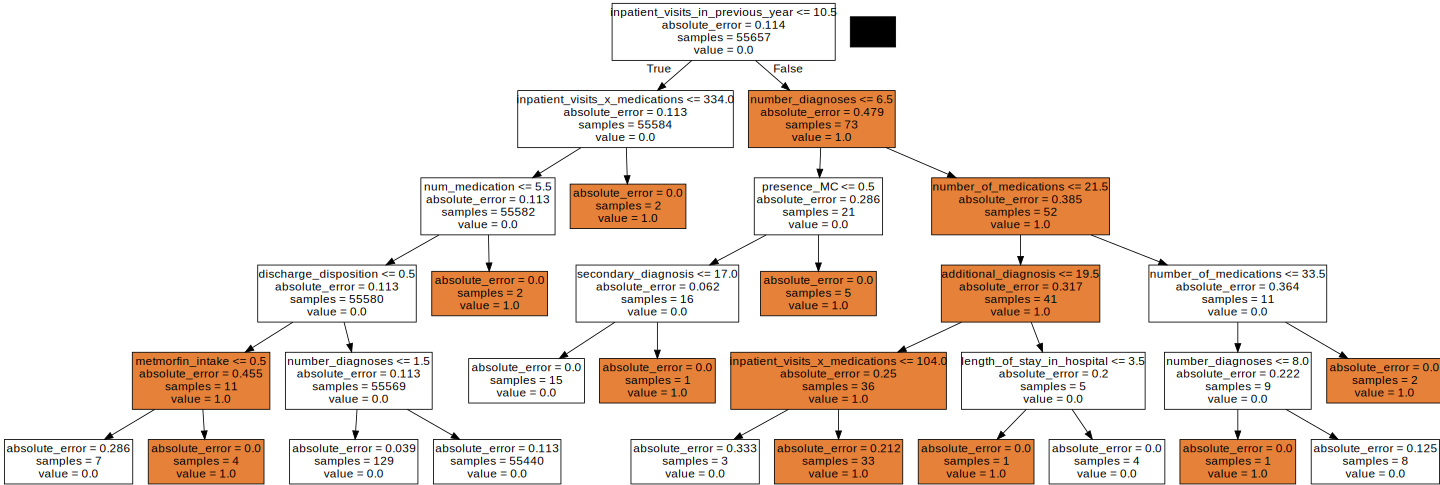

In [1328]:
import pydotplus
import graphviz
plot_tree(dt_mae)

experimental = ["inpatient_visits_in_previous_year", "number_diagnoses", "inpatient_visits_x_medications", "num_medication", "presence_MC", "number_of_medications", "discharge_disposition", "secondary_diagnosis", "additional_diagnosis", "number_diagnoses", "length_of_stay_in_hospital", "metmorfin_intake", "primary_diagnosis"]

import scipy.stats as stats
from scipy.stats import chi2_contingency
chi_droupout = []
def TestIndependence(X,y,alpha=0.05): 
    for var in X:    
        dfObserved = pd.crosstab(y,data_enc[var]) 
        chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
        dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
        if p>=alpha:
            chi_droupout.append(var)
    return chi_droupout

chi_droupout = TestIndependence(data_enc[cat_features], y_binary)

chi_droupout

from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(data_enc[cat_features], y_binary)
mutual_info_series = pd.Series(mutual_info, index=data_enc[cat_features].columns)
sorted_mutual_info = mutual_info_series.sort_values(ascending=False)

mutual = ((sorted_mutual_info[sorted_mutual_info == 0]).index).to_list()

mutual

#Logistic Regression:
#no of features
nof_list=np.arange(1,12)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled_b,y_train_b)
    X_val_rfe = rfe.transform(X_val_num_scaled_b)
    model.fit(X_train_rfe,y_train_b)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train_b)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_val_b)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
    #adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index = X_train_num_scaled_b.columns)
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

plt.plot(list(range(1,12)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,12)), val_score_list, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

model = LogisticRegression()
    
rfe_cv = RFECV(estimator = model,cv = 10)
X_train_rfe = rfe_cv.fit_transform(X_train_num_scaled_b,y_train_b)
X_val_rfe = rfe_cv.transform(X_val_num_scaled_b)
model.fit(X_train_rfe,y_train_b)
    
train_score = model.score(X_train_rfe,y_train_b)
val_score = model.score(X_val_rfe,y_val_b)
   
#adding mention of variables to keep
features_to_select = pd.Series(rfe_cv.support_, index = X_train_num_scaled_b.columns)
        
print("Optimum number of features:",len(features_to_select[ features_to_select == True]))
print("Score with a features: %f" % val_score)
print(f"Features to select: \n{features_to_select}")

def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

important = ['age', 'payer_code', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'discharge_disposition', 'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses', 'prescribed_diabetes_meds', 'med_spe', 'presence_MC', 'num_medication', 'insulin_intake', 'metmorfin_intake', 'comorbidity_score', 'inpatient_visits_x_medications']

reg = LassoCV()

reg.fit(X_train_num_scaled_b, y_train_b)
coef = pd.Series(reg.coef_, index = X_train_num_scaled_b.columns)
coef.sort_values()
plot_importance(coef,'Lasso')

reg = RidgeCV()

reg.fit(X_train_num_scaled_b, y_train_b)
coef = pd.Series(reg.coef_, index = X_train_num_scaled_b.columns)
coef.sort_values()
plot_importance(coef,'Ridge')

from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
model.fit(X, y_binary)
non_zero_indices = model.coef_.nonzero()[0]
selected_features = X.columns[non_zero_indices]
print("Selected Features:", selected_features.tolist())

from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X, y_binary)
high_score_features = np.where(mutual_info > 0.1)[0]

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_full = PCA()
pca_full.fit(X)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

n_components = 8
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

data_enc.drop(columns = "average_pulse_bpm", inplace = True)

_________________

In [1330]:
X = data_enc
num_models = 6
n_splits = 5 
f1_scores = []
conf_matrices = []
train_f1_scores = []

cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

for train_index, test_index in cv.split(X, y_binary):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]
    class_one = X_train[y_train == 1]
    class_zero = X_train[y_train == 0]
    subsets = np.array_split(class_zero.sample(frac=1), num_models)
    models = []
    for sub in subsets:
        X_sub = pd.concat([class_one, sub])
        y_sub = np.concatenate([np.ones(len(class_one)), np.zeros(len(sub))])
        model = HistGradientBoostingClassifier(min_samples_leaf=20, max_iter=100, max_depth=4, learning_rate=0.1)
        model.fit(X_sub, y_sub)
        models.append(model)
    
    train_ensemble_p = np.mean(np.array([m.predict_proba(X_train)[:, 1] for m in models]), axis=0)
    train_ensemble_p = np.round(train_ensemble_p).astype(int)
    train_fold_f1 = f1_score(y_train, train_ensemble_p)
    train_f1_scores.append(train_fold_f1)
    
    all_p = np.array([m.predict_proba(X_test)[:, 1] for m in models])
    ensemble_p = np.mean(all_p, axis=0)
    ensemble_p = np.round(ensemble_p).astype(int)
    fold_f1 = f1_score(y_test, ensemble_p)
    f1_scores.append(fold_f1)
    fold_conf_matrix = confusion_matrix(y_test, ensemble_p)
    conf_matrices.append(fold_conf_matrix)

average_f1 = np.mean(f1_scores)
print("Avg Formula1", average_f1)
total_conf_matrix = np.sum(conf_matrices, axis=0)
print("Neo take the red pill\n", total_conf_matrix)
total_train_f1_scores = np.mean(train_f1_scores)
print("Train F1 Score:", total_train_f1_scores)

Avg Formula1 0.2825796851500179
Neo take the red pill
 [[48901 12748]
 [ 4523  3400]]
Train F1 Score: 0.3093660213317456


In [1388]:
data_originial_columns = ['race', 'gender', 'age', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'average_pulse_bpm', 'discharge_disposition', 'admission_source',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'primary_diagnosis', 'secondary_diagnosis',
       'additional_diagnosis', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result', 'change_in_meds_during_hospitalization',
       'prescribed_diabetes_meds',
       'med_spe', 'presence_MD', 'presence_MC', 'no_insurande', 'is_black']

In [1389]:
X = data_enc[data_originial_columns]
num_models = 6
n_splits = 5 
f1_scores = []
conf_matrices = []
train_f1_scores = []

cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

for train_index, test_index in cv.split(X, y_binary):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]
    class_one = X_train[y_train == 1]
    class_zero = X_train[y_train == 0]
    subsets = np.array_split(class_zero.sample(frac=1), num_models)
    models = []
    for sub in subsets:
        X_sub = pd.concat([class_one, sub])
        y_sub = np.concatenate([np.ones(len(class_one)), np.zeros(len(sub))])
        model = HistGradientBoostingClassifier(min_samples_leaf=70, max_iter=350, max_depth=10, learning_rate=0.1, random_state=0)
        model.fit(X_sub, y_sub)
        models.append(model)
    
    train_ensemble_p = np.mean(np.array([m.predict_proba(X_train)[:, 1] for m in models]), axis=0)
    train_ensemble_p = np.round(train_ensemble_p).astype(int)
    train_fold_f1 = f1_score(y_train, train_ensemble_p)
    train_f1_scores.append(train_fold_f1)
    
    all_p = np.array([m.predict_proba(X_test)[:, 1] for m in models])
    ensemble_p = np.mean(all_p, axis=0)
    ensemble_p = np.round(ensemble_p).astype(int)
    fold_f1 = f1_score(y_test, ensemble_p)
    f1_scores.append(fold_f1)
    fold_conf_matrix = confusion_matrix(y_test, ensemble_p)
    conf_matrices.append(fold_conf_matrix)

average_f1 = np.mean(f1_scores)
print("Avg Formula1", average_f1)
total_conf_matrix = np.sum(conf_matrices, axis=0)
print("Neo take the red pill\n", total_conf_matrix)
total_train_f1_scores = np.mean(train_f1_scores)
print("Train F1 Score:", total_train_f1_scores)

Avg Formula1 0.283976547045585
Neo take the red pill
 [[48401 13248]
 [ 4420  3503]]
Train F1 Score: 0.33803742827715005


In [1331]:
X = data_enc
num_models = 6
n_splits = 5 
f1_scores = []
conf_matrices = []
train_f1_scores = []

cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

for train_index, test_index in cv.split(X, y_binary):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]
    class_one = X_train[y_train == 1]
    class_zero = X_train[y_train == 0]
    subsets = np.array_split(class_zero.sample(frac=1), num_models)
    models = []
    for sub in subsets:
        X_sub = pd.concat([class_one, sub])
        y_sub = np.concatenate([np.ones(len(class_one)), np.zeros(len(sub))])
        model = HistGradientBoostingClassifier(min_samples_leaf=70, max_iter=350, max_depth=10, learning_rate=0.1, random_state=0)
        model.fit(X_sub, y_sub)
        models.append(model)
    
    train_ensemble_p = np.mean(np.array([m.predict_proba(X_train)[:, 1] for m in models]), axis=0)
    train_ensemble_p = np.round(train_ensemble_p).astype(int)
    train_fold_f1 = f1_score(y_train, train_ensemble_p)
    train_f1_scores.append(train_fold_f1)
    
    all_p = np.array([m.predict_proba(X_test)[:, 1] for m in models])
    ensemble_p = np.mean(all_p, axis=0)
    ensemble_p = np.round(ensemble_p).astype(int)
    fold_f1 = f1_score(y_test, ensemble_p)
    f1_scores.append(fold_f1)
    fold_conf_matrix = confusion_matrix(y_test, ensemble_p)
    conf_matrices.append(fold_conf_matrix)

average_f1 = np.mean(f1_scores)
print("Avg Formula1", average_f1)
total_conf_matrix = np.sum(conf_matrices, axis=0)
print("Neo take the red pill\n", total_conf_matrix)
total_train_f1_scores = np.mean(train_f1_scores)
print("Train F1 Score:", total_train_f1_scores)

Avg Formula1 0.28380791965623053
Neo take the red pill
 [[48391 13258]
 [ 4421  3502]]
Train F1 Score: 0.33265111169349876


In [1325]:
X = data_enc[important]
num_models = 6
n_splits = 5 
f1_scores = []
conf_matrices = []
train_f1_scores = []


cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

for train_index, test_index in cv.split(X, y_binary):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]
    class_one = X_train[y_train == 1]
    class_zero = X_train[y_train == 0]
    subsets = np.array_split(class_zero.sample(frac=1), num_models)
    models = []
    for sub in subsets:
        X_sub = pd.concat([class_one, sub])
        y_sub = np.concatenate([np.ones(len(class_one)), np.zeros(len(sub))])
        model = HistGradientBoostingClassifier(min_samples_leaf=70, max_iter=350, max_depth=10, learning_rate=0.1, random_state=0)
        model.fit(X_sub, y_sub)
        models.append(model)
        
    train_ensemble_p = np.mean(np.array([m.predict_proba(X_train)[:, 1] for m in models]), axis=0)
    train_ensemble_p = np.round(train_ensemble_p).astype(int)
    train_fold_f1 = f1_score(y_train, train_ensemble_p)
    train_f1_scores.append(train_fold_f1)
    
    all_p = np.array([m.predict_proba(X_test)[:, 1] for m in models])
    ensemble_p = np.mean(all_p, axis=0)
    ensemble_p = np.round(ensemble_p).astype(int)
    fold_f1 = f1_score(y_test, ensemble_p)
    f1_scores.append(fold_f1)
    fold_conf_matrix = confusion_matrix(y_test, ensemble_p)
    conf_matrices.append(fold_conf_matrix)

average_f1 = np.mean(f1_scores)
print("Avg Formula1", average_f1)
total_conf_matrix = np.sum(conf_matrices, axis=0)
print("Neo take the red pill\n", total_conf_matrix)
total_train_f1_scores = np.mean(train_f1_scores)
print("Train F1 Score:", total_train_f1_scores)

Avg Formula1 0.28688198086769
Neo take the red pill
 [[48343 13306]
 [ 4369  3554]]
Train F1 Score: 0.3283939051149268


In [1326]:
X = data_enc[important]
num_models = 6
n_splits = 5 
f1_scores = []
conf_matrices = []
train_f1_scores = []


cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

for train_index, test_index in cv.split(X, y_binary):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]
    class_one = X_train[y_train == 1]
    class_zero = X_train[y_train == 0]
    subsets = np.array_split(class_zero.sample(frac=1), num_models)
    models = []
    for sub in subsets:
        X_sub = pd.concat([class_one, sub])
        y_sub = np.concatenate([np.ones(len(class_one)), np.zeros(len(sub))])
        model = HistGradientBoostingClassifier(max_depth=15, max_iter=350, min_samples_leaf=70,
                                random_state=0)
        model.fit(X_sub, y_sub)
        models.append(model)
        
    train_ensemble_p = np.mean(np.array([m.predict_proba(X_train)[:, 1] for m in models]), axis=0)
    train_ensemble_p = np.round(train_ensemble_p).astype(int)
    train_fold_f1 = f1_score(y_train, train_ensemble_p)
    train_f1_scores.append(train_fold_f1)
    
    all_p = np.array([m.predict_proba(X_test)[:, 1] for m in models])
    ensemble_p = np.mean(all_p, axis=0)
    ensemble_p = np.round(ensemble_p).astype(int)
    fold_f1 = f1_score(y_test, ensemble_p)
    f1_scores.append(fold_f1)
    fold_conf_matrix = confusion_matrix(y_test, ensemble_p)
    conf_matrices.append(fold_conf_matrix)

average_f1 = np.mean(f1_scores)
print("Avg Formula1", average_f1)
total_conf_matrix = np.sum(conf_matrices, axis=0)
print("Neo take the red pill\n", total_conf_matrix)
total_train_f1_scores = np.mean(train_f1_scores)
print("Train F1 Score:", total_train_f1_scores)

Avg Formula1 0.2868593156077969
Neo take the red pill
 [[48342 13307]
 [ 4369  3554]]
Train F1 Score: 0.3273314731619571


## HGB

In [561]:
X = data_enc.copy()
labelencoder = LabelEncoder()
y_binary = labelencoder.fit_transform(X['readmitted_binary'])
X.drop(columns = "readmitted_binary", inplace = True)

In [531]:
encounter_ids = test_enc["encounter_id"]
test_enc.drop(columns = "encounter_id", inplace = True)

death_columns = ["discharge_" + category for category in ["Expired", "Hospice / medical facility", "Hospice / home", "Expired at home. Medicaid only, hospice.", "Expired in a medical facility. Medicaid only, hospice."]]

existing_death_columns = [col for col in death_columns if col in test_enc.columns]

test_predictions = np.mean(np.array([model.predict_proba(test_enc)[:, 1] for model in best_model]), axis=0)
test_predictions = np.round(test_predictions).astype(int)

if existing_death_columns:
    deceased_indicator = test_enc[existing_death_columns].any(axis=1)
    test_predictions[deceased_indicator] = 0 
    
to_binary = {0: 'No', 1: 'Yes'}

final_ensemble_prediction_converted = list(map(to_binary.get, test_predictions))
final_test_predictions = pd.DataFrame({
    'encounter_id': encounter_ids, 
    'readmitted_binary': final_ensemble_prediction_converted
})

final_test_predictions.to_csv('mickey.csv', index=False)

# SAMPLING

In [73]:
#pip install imbalanced-learn

In [2]:
#pip install -U imbalanced-learn

In [1145]:
hgb = HistGradientBoostingClassifier(
                                       learning_rate=0.05,
                                       random_state=7,
                                       max_iter= 60,
                                       max_leaf_nodes= 40)

In [1148]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import numpy as np

def evaluate_model(sampling, X, y, n_splits=5):
 
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    training_f1_scores = []
    testing_f1_scores = []
    training_accuracies = []
    testing_accuracies = []
    cumulative_confusion_matrix_train = np.zeros((2, 2))  # Assuming binary classification
    cumulative_confusion_matrix_test = np.zeros((2, 2))  # Assuming binary classification

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train = apply_sampling(sampling, X_train, y_train)
        model = hgb
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        training_f1_scores.append(f1_score(y_train, y_train_pred))
        testing_f1_scores.append(f1_score(y_test, y_test_pred))
        training_accuracies.append(accuracy_score(y_train, y_train_pred))
        testing_accuracies.append(accuracy_score(y_test, y_test_pred))
        cumulative_confusion_matrix_train += confusion_matrix(y_train, y_train_pred)
        cumulative_confusion_matrix_test += confusion_matrix(y_test, y_test_pred)

    print(f"Training F1 Score: {np.mean(training_f1_scores):.4f}")
    print(f"Training Accuracy: {np.mean(training_accuracies):.4f}")

    print(f"Testing F1 Score: {np.mean(testing_f1_scores):.4f}")
    print(f"Testing Accuracy: {np.mean(testing_accuracies):.4f}")
    print("Testing Matrix:\n", cumulative_confusion_matrix_test.astype(int))

In [1144]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from sklearn.utils import resample

def apply_sampling(method, X, y):
    X_samp = None
    y_samp = None
    if method == "rus":
        rus = RandomUnderSampler(random_state=42)
        X_samp, y_samp = rus.fit_resample(X, y)
    if method == "ros":
        ros = RandomOverSampler(random_state=42)
        X_samp, y_samp = ros.fit_resample(X, y)
    if method == "SMOTE":
        smote = SMOTE(random_state=42)
        X_samp, y_samp = smote.fit_resample(X,y)
    if method == "ADASYN":
        adasyn = ADASYN(random_state=42)
        X_samp, y_samp = adasyn.fit_resample(X,y)
    if method == "other":
        n_samples = len(y)
        n_positive = np.sum(y)
        n_negative = n_samples - n_positive
        pmi = (n_samples - 3) / (2 * (n_negative + 3)) - 1 / n_positive
        pma = (n_samples - 3) / (2 * (n_positive + 3)) - 1 / n_negative
        X_res, y_res = resample(X, y, n_samples=int(n_samples * pmi))
        smote = SMOTE()
        X_res, y_res = smote.fit_resample(X_res, y_res)
        rus = RandomUnderSampler()
        X_samp, y_samp = rus.fit_resample(X_res, y_res)

    
    return X_samp, y_samp

In [390]:
hgb = HistGradientBoostingClassifier( learning_rate=0.05,
                                       random_state=7,
                                       max_iter= 60,
                                       max_leaf_nodes= 40)

In [1149]:
#RUS
evaluate_model("rus", X, y_binary, 5)

Training F1 Score: 0.6894
Training Accuracy: 0.6946
Testing F1 Score: 0.2707
Testing Accuracy: 0.6345
Testing Matrix:
 [[39427 22222]
 [ 3206  4717]]


In [1150]:
#ROS
evaluate_model("ros", X, y_binary, 5)

Training F1 Score: 0.6757
Training Accuracy: 0.6749
Testing F1 Score: 0.2772
Testing Accuracy: 0.6540
Testing Matrix:
 [[40888 20761]
 [ 3309  4614]]


In [1151]:
#SMOTE
evaluate_model("SMOTE", X, y_binary, 5)

Training F1 Score: 0.8305
Training Accuracy: 0.8418
Testing F1 Score: 0.1491
Testing Accuracy: 0.8184
Testing Matrix:
 [[55827  5822]
 [ 6815  1108]]


In [1152]:
# ADASYN
evaluate_model("ADASYN", X, y_binary, 5)

Training F1 Score: 0.8332
Training Accuracy: 0.8428
Testing F1 Score: 0.1447
Testing Accuracy: 0.8179
Testing Matrix:
 [[55832  5817]
 [ 6851  1072]]


In [1153]:
evaluate_model("other", X, y_binary, 5)

Training F1 Score: 0.8231
Training Accuracy: 0.8348
Testing F1 Score: 0.1772
Testing Accuracy: 0.8071
Testing Matrix:
 [[54705  6944]
 [ 6477  1446]]
